In [1]:
# target accuracy: 81%

# Kaggle: Titanic: Machine Learning from Disaster

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,StratifiedKFold,learning_curve
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,Imputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,VotingClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [3]:
# read datasets
df = pd.read_csv("train.csv")
ddf = pd.read_csv("test.csv")

In [4]:
# check the data
df.head()
#ddf.isnull().sum()
#ddf.Embarked.unique()
#Counter(ddf.Embarked)
#ddf.Fare.unique()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Save away the id columns for submission.
y_id = ddf.PassengerId

In [6]:
# feature massage

# Counter(df['Embarked'])
# The majority of the column "Embarked" is 'S' so fill na with S
df['Embarked'].fillna(value='S',inplace=True)
ddf['Fare'].fillna(value= np.mean(ddf.Fare),inplace=True)

for ff in [df,ddf]:
    ff['family_size'] = ff['Parch'] + ff['SibSp']
    ff['fare_pp'] = ff['Fare'] / (ff['family_size'] + 1) #+1 is for the him/her self
    # Although the name itself does not appear to give some useful info, titles are worth investigating
    # Split the names twice by ',' and '.'
    ff['title'] = (ff['Name'].str.split(',').map(lambda x:x[1])).str.split('.').map(lambda x:x[0])
    ff['Alone'] = ff['family_size'] == 0

    # drop unnecessary columns.
    #ff.drop(['PassengerId','Name','Ticket','Cabin','Parch','SibSp','Fare'],axis=1,inplace=True)
    ff.drop(['PassengerId','Name','Ticket','Cabin','Fare'],axis=1,inplace=True)

In [7]:
# As you can see the below, there are many NaN in only Age column
df.isnull().sum()
ddf.isnull().sum()

Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Embarked        0
family_size     0
fare_pp         0
title           0
Alone           0
dtype: int64

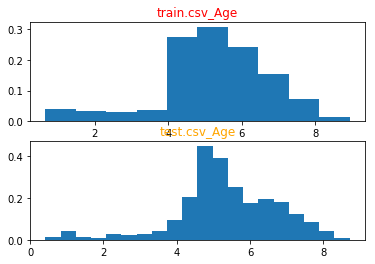

In [8]:
# Handle a histogram with care if data has any NaN value
# Below histogram does not appear to follow a normal distribution.

plt.figure(1)
plt.subplot(211)
plt.hist((df['Age'].dropna())**0.5,normed=True,bins=10)
plt.title("train.csv_Age",color='red')

plt.subplot(212)
plt.hist((ddf.Age.dropna())**0.5,normed=True,bins=20)
plt.title("test.csv_Age",color='orange')
plt.show()

In [9]:
# Fill NaN with median which is more robust than mean

for ff in [df,ddf]:
    imputer = Imputer(missing_values='NaN',strategy='median')
    ff['Age'] = imputer.fit_transform(np.array(ff['Age']).reshape(-1,1))


In [10]:
df_object = list(df.dtypes[(df.dtypes != 'int64') & (df.dtypes != 'float64')].index)
ddf_object = list(ddf.dtypes[(df.dtypes != 'int64') & (ddf.dtypes != 'float64')].index)
(df_object,ddf_object)

(['Sex', 'Embarked', 'title', 'Alone'], ['Sex', 'Embarked', 'title', 'Alone'])

In [11]:
ddf.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked,family_size,fare_pp,title,Alone
0,3,male,34.5,0,0,Q,0,7.829200,Mr,True
1,3,female,47.0,1,0,S,1,3.500000,Mrs,False
2,2,male,62.0,0,0,Q,0,9.687500,Mr,True
3,3,male,27.0,0,0,S,0,8.662500,Mr,True
4,3,female,22.0,1,1,S,2,4.095833,Mrs,False


In [12]:
print("test.csv types")
ddf.dtypes

test.csv types


Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Embarked        object
family_size      int64
fare_pp        float64
title           object
Alone             bool
dtype: object

### Title Extraction

In [13]:
df['Embarked'].unique()
df['title'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer'], dtype=object)

In [14]:
#Since the dim of the matrix for train and test dataset do not match due to the various title
# we need to replace some titles with more common one.

title_sex = pd.crosstab(df['title'], df['Sex'])
title_sex['total'] = title_sex.female + title_sex.male
title_sex.sort_values('total',ascending=False,inplace=True)
title_sex

Sex,female,male,total
title,,,
Mr,0,517,517
Miss,182,0,182
Mrs,125,0,125
Master,0,40,40
Dr,1,6,7
Rev,0,6,6
Major,0,2,2
Col,0,2,2
Mlle,2,0,2


In [15]:
df['title'].replace('Mlle','Miss',inplace=True)
df['title'].replace('Ms','Miss',inplace=True)
df['title'].replace('Mme','Mrs',inplace=True)

remove_list_df = list(title_sex.iloc[4:,:].index)
df['title'].replace(remove_list_df,'Rare',inplace=True)

In [16]:
title_sex_ddf = pd.crosstab(ddf['title'], ddf['Sex'])
title_sex_ddf['total'] = title_sex_ddf.female + title_sex_ddf.male
title_sex_ddf.sort_values('total',ascending=False,inplace=True)
title_sex_ddf


Sex,female,male,total
title,,,
Mr,0,240,240
Miss,78,0,78
Mrs,72,0,72
Master,0,21,21
Col,0,2,2
Rev,0,2,2
Dona,1,0,1
Dr,0,1,1
Ms,1,0,1


In [17]:
ddf['title'].replace('Ms','Miss',inplace=True)
remove_list_ddf = list(title_sex_ddf.iloc[4:,:].index)
ddf['title'].replace(remove_list_ddf,'Rare',inplace=True)

### Age & Fair & Family Size Cutting 

In [18]:
#pd.crosstab(pd.cut(df['Age'],6),df['Survived'])
#sorted(df['Age'].unique())

In [19]:
#df['Age_Cut'] = pd.cut(df.Age,6)
#ddf['Age_Cut'] = pd.cut(ddf.Age,6)

for ff in [df,ddf]:
    #ff['Age_Cut_1'] = ff['Age'] < 5
    #ff['Age_Cut_2'] = (5 <= ff['Age']) & (ff['Age'] < 18)
    #ff['Age_Cut_3'] = (18 <= ff['Age']) & (ff['Age'] < 35)
    #ff['Age_Cut_4'] = (35 <= ff['Age']) & (ff['Age'] < 50)
    #ff['Age_Cut_5'] = (50 <= ff['Age']) & (ff['Age'] < 60)
    #ff['Age_Cut_6'] = (60 <= ff['Age'])
    
    #ff['Fare_1'] = ff['fare_pp'] < 20
    #ff['Fare_2'] = (20 <= ff['fare_pp']) & (ff['fare_pp'] < 40)
    #ff['Fare_3'] = (40 <= ff['fare_pp']) & (ff['fare_pp'] < 100)
    #ff['Fare_4'] = (100 <= ff['fare_pp'])

    ff['Fsize_1'] = ff['family_size'].map(lambda f: 1 if f==0 else 0)
    ff['Fsize_2'] = ff['family_size'].map(lambda f: 1 if f==1 else 0)
    ff['Fsize_3'] = ff['family_size'].map(lambda f: 1 if (f==2)|(f==3) else 0)
    ff['Fsize_4'] = ff['family_size'].map(lambda f: 1 if f>4 else 0)

In [20]:
#fare_list = ['Fare_' + str(number) for number in range(1,5)]
#age_list = ['Age_Cut_' + str(number) for number in range(1,7)]
family_list = ['Fsize_' + str(number) for number in range(1,5)]

In [21]:
ddf.head()
ddf.Pclass.unique()

array([3, 2, 1])

In [22]:
# convert object type to the type that pandas can process
# LabelEncoder itself is not enough for converting for efficiency.
# Since just converting the type using label encoder can lead the machine misunderstand that the bigger
# number of label more important; therefore, OneHotEncoder process must be performed right after the label encoder.

le = LabelEncoder()
for ff in [df,ddf]:
    #for name in df_object + ['Pclass'] + age_list + family_list:
    for name in df_object + ['Pclass'] + family_list:
        ff[name] = le.fit_transform(ff[name].astype(str))
        ff[name] = ff[name].astype('category')
        
#for f_num in age_list + family_list:
    #for ff in [df,ddf]:
        #ff[f_num] = ff[f_num].astype('float64')

In [23]:
for ff in [df,ddf]:
    ff.fare_pp.map(lambda x: np.log(x) if x>0 else 0)


In [24]:
#df['Parch_img'] = 0

## OneHotEncoder

In [25]:
# We could use an integer encoding directly, rescaled where needed. This may work for problems
# where there is a natural ordinal relationship between the categories, and in turn the integer 
# values, such as labels for temperature 'cold','warm', and 'hot'. However, if there is 
# no ordinal relationship between the categories and allowing the representation to lean on any such
# relationship might be damaging to learning to solve the problem, i.e) 'dog' and 'cat'
df.dtypes
#df_category = ['Pclass','Sex','Embarked','family_size','title','Alone','Age_Cut','Age','fare_pp']
#df_category = ['Pclass','Sex','Embarked','family_size','title','Alone','Age']
df_category = ['Pclass','Sex','Embarked','family_size','title','Alone']
df_category

['Pclass', 'Sex', 'Embarked', 'family_size', 'title', 'Alone']

In [26]:
ohe = OneHotEncoder(sparse=False)

arr_pclass = ohe.fit_transform(np.array(df['Pclass']).reshape(-1,1))
#arr_gender = ohe.fit_transform(np.array(df['Sex']).reshape(-1,1))
arr_embarked = ohe.fit_transform(np.array(df['Embarked']).reshape(-1,1))
#arr_family = ohe.fit_transform(np.array(df['family_size']).reshape(-1,1))
arr_title = ohe.fit_transform(np.array(df['title']).reshape(-1,1))
#arr_alone = ohe.fit_transform(np.array(df['Alone']).reshape(-1,1))
#arr_agecut = ohe.fit_transform(np.array(df['Age_Cut']).reshape(-1,1))
#arr_parch = ohe.fit_transform(np.array(df['Parch']).reshape(-1,1))
#arr_comb = np.concatenate([arr_pclass,arr_gender,arr_embarked,arr_family,arr_title,arr_alone,arr_agecut],axis=1)
#arr_comb = np.concatenate([arr_pclass,arr_gender,arr_embarked,arr_family,arr_title,arr_alone],axis=1)
arr_comb = np.concatenate([arr_pclass,arr_embarked,arr_title],axis=1)
df = pd.concat([df,pd.DataFrame(arr_comb)], axis=1)
df.drop(df_category,axis=1,inplace=True)
df.head()

,Survived,Age,SibSp,Parch,fare_pp,Fsize_1,Fsize_2,Fsize_3,Fsize_4,0,1,2,3,4,5,6,7,8,9,10
0,0,22.0,1,0,3.62500,0,1,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,38.0,1,0,35.64165,0,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,26.0,0,0,7.92500,1,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1,35.0,1,0,26.55000,0,1,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,35.0,0,0,8.05000,1,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [27]:
ohe = OneHotEncoder(sparse=False)

ar_pclass = ohe.fit_transform(np.array(ddf['Pclass']).reshape(-1,1))
#ar_gender = ohe.fit_transform(np.array(ddf['Sex']).reshape(-1,1))
ar_embarked = ohe.fit_transform(np.array(ddf['Embarked']).reshape(-1,1))
#ar_family = ohe.fit_transform(np.array(ddf['family_size']).reshape(-1,1))
ar_title = ohe.fit_transform(np.array(ddf['title']).reshape(-1,1))
#ar_alone = ohe.fit_transform(np.array(ddf['Alone']).reshape(-1,1))
#ar_agecut = ohe.fit_transform(np.array(ddf['Age_Cut']).reshape(-1,1))
#ar_parch = ohe.fit_transform(np.array(ddf['Parch']).reshape(-1,1))
#ar_comb = np.concatenate([ar_pclass,ar_gender,ar_embarked,ar_family,ar_title,ar_alone,ar_agecut],axis=1)
#ar_comb = np.concatenate([ar_pclass,ar_gender,ar_embarked,ar_family,ar_title,ar_alone],axis=1)
ar_comb = np.concatenate([ar_pclass,ar_embarked,ar_title],axis=1)
ddf = pd.concat([ddf,pd.DataFrame(ar_comb)], axis=1)
ddf.drop(df_category,axis=1,inplace=True)
ddf.head()

,Age,SibSp,Parch,fare_pp,Fsize_1,Fsize_2,Fsize_3,Fsize_4,0,1,2,3,4,5,6,7,8,9,10
0,34.5,0,0,7.829200,1,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,47.0,1,0,3.500000,0,1,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,62.0,0,0,9.687500,1,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,27.0,0,0,8.662500,1,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,22.0,1,1,4.095833,0,0,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [28]:
# check correlations and delete if there are highly correlated columns

#abs(df.corr()['Survived']).sort_values(ascending=False)
#sel_col = list(df.corr()['Survived'][(abs(df.corr()['Survived']).sort_values(ascending=False) >0.2)].index)
#sel_col

#abs(df.corr()['Survived']).sort_values(ascending=False)

In [29]:
# Full Columns
# split the data into four pieces (X_train,test, y_train,test)
y = df["Survived"]
X = df.loc[:,[x for x in df.columns if x !="Survived"]]
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [30]:
#Selected Columns
#y = df['Survived']
#X = df.loc[:,[x for x in sel_col if x !="Survived"]]
#X_train,X_test,y_train,y_test = train_test_split(X,y)

In [31]:
#ddf = ddf.loc[:,[x for x in sel_col if x !="Survived"]]

In [32]:
df.shape

(891, 20)

In [33]:
ddf.head()

,Age,SibSp,Parch,fare_pp,Fsize_1,Fsize_2,Fsize_3,Fsize_4,0,1,2,3,4,5,6,7,8,9,10
0,34.5,0,0,7.829200,1,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,47.0,1,0,3.500000,0,1,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,62.0,0,0,9.687500,1,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,27.0,0,0,8.662500,1,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,22.0,1,1,4.095833,0,0,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [34]:
kfold = StratifiedKFold(n_splits=10)

## RandomForest

In [35]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None,80,90,100,110],
              "max_features": [1,2,3,4,5,12,17],
              #"min_samples_split": [1,3,8,10,12],
              "min_samples_leaf": [2,3,4,5],
              "bootstrap": [True],
              "n_estimators" :[500,1000,2000],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsRFC.fit(X_train,y_train)
RFC_best = gsRFC.best_estimator_
gsRFC.best_score_
print(gsRFC.best_params_)

# L {'max_depth': 35, 'min_samples_leaf': 3, 'n_estimators': 150} -> 0.83408
# {'max_depth': 73, 'min_samples_leaf': 3, 'n_estimators': 170} -> 0.8609
#{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 4, 'n_estimators': 2000}
#{'bootstrap': True, 'criterion': 'gini', 'max_depth': 90, 'max_features': 17, 'min_samples_leaf': 5, 'n_estimators': 1000}
#{'bootstrap': True, 'criterion': 'gini', 'max_depth': 110, 'max_features': 17, 'min_samples_leaf': 3, 'n_estimators': 1000}
# {'bootstrap': True, 'criterion': 'gini', 'max_depth': 80, 'max_features': 12, 'min_samples_leaf': 4, 'n_estimators': 500}
#y_predicted = clf.predict(X_test)
#y_submission = clf.predict(ddf)
#accuracy_score(y_test,y_predicted)

Fitting 20 folds for each of 420 candidates, totalling 8400 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 46.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 61.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 77.1min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 97.4min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 116.3min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 138.1min
[Parallel(n_jobs=-1)]: Done 8400 out of 8400 | elapsed: 161.0min finished


{'bootstrap': True, 'criterion': 'gini', 'max_depth': 80, 'max_features': 12, 'min_samples_leaf': 4, 'n_estimators': 500}


In [49]:
y_predicted = gsRFC.predict(X_test)
y_submission = gsRFC.predict(ddf)
accuracy_score(y_test,y_predicted)

0.820627802690583

In [37]:
#optimized_forest = RandomForestClassifier(n_jobs = -1, max_features='sqrt',n_estimators=170)
#optimized_forest.fit(X_train,y_train)
#y_predicted = optimized_forest.predict(X_test)
#accuracy_score(y_test,y_predicted)

## AdaBoostClassifier

In [38]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[500,1000,2000],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1,verbose = 1)
gsadaDTC.fit(X_train,y_train)
ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_
print(gsadaDTC.best_params_)

#{'algorithm': 'SAMME.R', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'learning_rate': 0.0001, 'n_estimators': 2000}
#{'algorithm': 'SAMME', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'learning_rate': 1.5, 'n_estimators': 1000}
#{'algorithm': 'SAMME.R', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'learning_rate': 0.1, 'n_estimators': 1000}
#{'algorithm': 'SAMME.R', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'learning_rate': 0.01, 'n_estimators': 1000}

Fitting 20 folds for each of 168 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 37.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 53.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 68.2min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 86.7min
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed: 90.0min finished


{'algorithm': 'SAMME.R', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'learning_rate': 0.01, 'n_estimators': 1000}


In [51]:
y_predicted = gsadaDTC.predict(X_test)
y_submission = gsadaDTC.predict(ddf)
accuracy_score(y_test,y_predicted)

0.75784753363228696

## ExtraTreesClassifier

In [40]:
ExtC = ExtraTreesClassifier()

ex_param_grid = {"n_estimators":[500,1000,2000],
              "max_depth":[None,50,80,90,100,110],
              "min_samples_leaf":[k for k in range(2,5)],
            #"min_samples_split": [1,3,8,10,12],
            "max_features": [1,2,3,4,5,12,17],
            "bootstrap":[True,False],
             "criterion":["gini"]}
                
gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsExtC.fit(X_train,y_train)
ExtC_best = gsExtC.best_estimator_
gsExtC.best_score_
print(gsExtC.best_params_)

#{'bootstrap': True, 'criterion': 'gini', 'max_depth': 100, 'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 500}
#{'bootstrap': True, 'criterion': 'gini', 'max_depth': 50, 'max_features': 3, 'min_samples_leaf': 4, 'n_estimators': 1000}

Fitting 20 folds for each of 756 candidates, totalling 15120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 45.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 58.1min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 72.1min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 87.0min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 103.8min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 121.7min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 141.6min
[Parallel(n_jobs=-1)]: Done 11242 tasks      | elapsed: 163.0min
[Parallel(n_jobs=-1)]: Done 12792 tasks      | elapsed

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 50, 'max_features': 3, 'min_samples_leaf': 4, 'n_estimators': 1000}


In [52]:
y_predicted = gsExtC.predict(X_test)
y_submission = gsExtC.predict(ddf)
accuracy_score(y_test,y_predicted)

0.82959641255605376

## GradientBoostingClassifier

In [42]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,300,500,1000],
              'learning_rate': [0.1, 0.05, 0.01,0.001,],
              'max_depth': [None,80,90,100,110],
              'min_samples_leaf': [100,150],
              'max_features': [1,2,3,4,5,12,17]
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsGBC.fit(X_train,y_train)
GBC_best = gsGBC.best_estimator_
gsGBC.best_score_
print(gsGBC.best_params_)
#{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': None, 'max_features': 12, 'min_samples_leaf': 100, 'n_estimators': 1000}
#{'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 100, 'n_estimators': 1000}
#{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 100, 'n_estimators': 1000}

Fitting 20 folds for each of 1120 candidates, totalling 22400 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 232 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done 511 tasks      | elapsed:   44.4s
[Parallel(n_jobs=4)]: Done 861 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 1344 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 1924 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 2603 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 3353 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done 4260 tasks      | elapsed:  7.4min
[Parallel(n_jobs=4)]: Done 5324 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done 6434 tasks      | elapsed: 11.2min
[Parallel(n_jobs=4)]: Done 7660 tasks      | elapsed: 13.4min
[Parallel(n_jobs=4)]: Done 8970 tasks      | elapsed: 15.8min
[Parallel(n_jobs=4)]: Done 10452 tasks      | elapsed: 18.3min
[Parallel(n_jobs=4)]: Done 11961 tasks      | elapsed: 21.0min
[Parallel(n_jobs=4)]: Done 13609 tasks      | elapsed: 24.0min
[Parallel

{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 100, 'n_estimators': 1000}


In [54]:
y_predicted = gsGBC.predict(X_test)
y_submission = gsGBC.predict(ddf)
accuracy_score(y_test,y_predicted)

0.81614349775784756

## Kernelized SVM

### rbf

In [44]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

gammas = [0.01,0.03,0.05,0.1]
Cs = [0.001,0.10,0.30,0.50,10,25,35]
#weight = ['balanced',{1:2},{1:3},{1:4},{1:5},{1:10}]
param_grid = dict(C=Cs,gamma=gammas)
grid = GridSearchCV(SVC(kernel='rbf',probability=True),param_grid=param_grid,cv=kfold,scoring="accuracy",n_jobs=-1,verbose=1)
grid.fit(X_train,y_train)
SVMC_best = grid.best_estimator_
grid.best_score_
print(grid.best_params_)

#y_predicted = grid.predict(X_test)

#ddf = scaler.fit_transform(ddf)
#y_submission = grid.predict(ddf)
#accuracy_score(y_test,y_predicted)

# {'C': 25, 'gamma': 0.001, cv=4}
#{'C': 0.3, 'gamma': 0.1}
#{'C': 0.1, 'gamma': 0.01}
#{'C': 10, 'gamma': 0.01}

Fitting 20 folds for each of 28 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   11.1s


{'C': 10, 'gamma': 0.01}


[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   19.8s finished


In [56]:
y_predicted = grid.predict(X_test)
y_submission = grid.predict(ddf)
accuracy_score(y_test,y_predicted)

0.82511210762331844

In [45]:
votingC = VotingClassifier(estimators = [('rfc',RFC_best), ('extc',ExtC_best),('svc',SVMC_best),
                                        ('adac',ada_best),('gbc',GBC_best)], voting='soft',n_jobs=-1)
votingC = votingC.fit(X_train,y_train)

#y_predicted = votingC.predict(X_test)
#accuracy_score(y_test,y_predicted)
y_submission = votingC.predict(ddf)
#accuracy_score(y_test,y_submission)

### polynomial

In [46]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.fit_transform(X_test)
#classifier = SVC(kernel = 'poly')
#svm_quick = classifier.fit(X_train,y_train)
#y_predicted = svm_quick.predict(X_test)
#y_submission = classifier.predict(ddf)
#accuracy_score(y_test,y_predicted)

## KNN

In [47]:
#n_folds = 4
#metrics = ['minkowski','euclidean','manhattan']
#weights = ['uniform','distance']
#numNeighbors = np.arange(5,10)
#param_grid = dict(metric=metrics,weights=weights,n_neighbors=numNeighbors)
#cv = StratifiedKFold(n_folds,shuffle=True)

#grid = GridSearchCV(KNeighborsClassifier(),param_grid=param_grid,cv=cv)
#grid.fit(X_train,y_train)
#print(grid.best_params_)
#y_predicted = grid.predict(X_test)
#accuracy_score(y_test,y_predicted)

#y_submission = grid.predict(ddf)

# Submission

In [57]:
my_submission = pd.DataFrame({'PassengerId':y_id,'Survived':y_submission})
my_submission.to_csv('submission0018.csv',index=False)